In [1]:
# data import
import zarr
import intake
from dask.diagnostics import ProgressBar


import numpy as np
import pandas as pd
import xarray as xr
import dask 
import datetime

xr.set_options(display_style='html')
import cftime
import nc_time_axis

import warnings
warnings.filterwarnings("ignore")

# progress bars for loops
from tqdm.notebook import tqdm  

In [2]:
def fix_lon(ds):
    '''
    adjust longitude to be [-180, 180]
    '''
    ds = ds.copy()
    
    ## TO DO FIGURE OUT HOW TO KEEP LONGITUDE ATTRIBUTES 
    if ds.lon.max()>180:
        ds.coords['lon'] = ((ds.coords['lon'] + 180) % 360 - 180) 
        ds = ds.sortby(ds.lon)

    return ds

def fix_time(ds):
    '''
    reformat time data to be a cftime.datetime object with year, month, day=1, calendar='proleptic_gregorian'
    '''
    ds = ds.copy()
    
    # get time tuples, in the form (year, month, ... )
    time_tuples = [t.timetuple() for t in ds.coords['time'].data]
    #ds.coords['time'] = [cftime.datetime(time_tuple[0], time_tuple[1], 1, calendar='proleptic_gregorian')
    #                     for time_tuple in time_tuples]
    
    ds.coords['time'] = [cftime.datetime(time_tuple[0], time_tuple[1], time_tuple[2], calendar='proleptic_gregorian')
                         for time_tuple in time_tuples]
    
    return ds


def wrapper(ds):
    '''
    clean up newly imported data
    '''
    ds = ds.copy()
    
    if ('longitude' in ds.dims) and ('latitude' in ds.dims):
        ds = ds.rename({'longitude':'lon', 'latitude': 'lat'}) # some models labelled dimensions differently...
    if ('bnds' in ds.dims): 
        ds=ds.drop_dims('bnds')
    if ('vertex' in ds.dims): 
        ds=ds.drop_dims('vertex')
    if ('height' in ds.dims): 
        ds=ds.drop_dims('height')
    if ('height' in ds): 
        ds=ds.drop_vars('height') 
    if ('depth' in ds.dims):
        ds=ds.drop_dims('depth')
    if ('depth' in ds): 
        ds=ds.drop_vars('depth') 
    
    
    # clean up the different calendars and get them all using the same cftime (hopefully)
    ds = fix_time(ds)
    # fix longitude values across all the models 
    ds = fix_lon(ds)
    return ds



### GLOBAL MEANS ###
def get_lat_name(ds):
    for lat_name in ['lat', 'latitude']:
        if lat_name in ds.coords:
            return lat_name
    raise RuntimeError("Couldn't find a latitude coordinate")

def global_mean(ds):
    """
    Calculate weighted global mean average
    """
    lat = ds[get_lat_name(ds)]
    weight = np.cos(np.deg2rad(lat))
    weight /= weight.mean()
    other_dims = set(ds.dims) - {'time'} - {'year'} - {'member_id'}
    return (ds * weight).mean(other_dims)

def region_select(ds, region_params):
    """
    subset a dataset by region
    """
    region_ds = ds.sel(lat=slice(*region_params['lat']), lon=slice(*region_params['lon']))
    return region_ds


### ANOMALIES ###

def anomalies(ds, model):
    '''
    Returns timeseries of anomalies (globally averaged) for a given dataset.
    '''
    try:  
        baseline = ds.sel(time = slice('1861', '1880')).groupby('time.month')
        ds_standard = (ds.groupby('time.month') - baseline.mean())/baseline.std()
        ds_anom = global_mean(ds_standard)
        return ds_anom
    except:
        print('***** error calculating ' + str(model) + ' anomalies *****')   

### RESPONSES ###

def responses(ds):
    """
    Calculate difference between early and late period.
    Lazy.
    """

    ds = ds.copy()
    
    early_start = '1861'
    early_end = '1880'
    early = ds.sel(time=slice(early_start, early_end)).mean(dim = 'time')
    
    late_start = '2050'
    late_end = '2100'
    late = ds.sel(time = slice(late_start, late_end)).mean(dim = 'time')
    
    difference = (late - early)/early.std()
    
    return difference

In [3]:
#variable_id = ['mrsos', 'pr', 'tas']
variable_id = ['mrso', 'pr']


source_id = ['ACCESS-CM2']
# source_id = [
#     'ACCESS-CM2', 'BCC-CSM2-MR', 'CAMS-CSM1-0',	'CNRM-CM6-1', 'CNRM-ESM2-1', 
#     'CanESM5-CanOE', 'EC-Earth3-Veg', 'FIO-ESM-2-0', 'GFDL-CM4',
#     'IPSL-CM6A-LR', 'MIROC-ES2L',  'MPI-ESM1-2-HR', 'MPI-ESM1-2-LR',
#     'MRI-ESM2-0', 'UKESM1-0-LL' , 'MIROC6', 'CanESM5' # trying these again with the new preprocessing	
# ]

#dropped = ['EC-Earth3', 'CESM2-WACCMC', 'CanESM5']#, #'MIROC6'

experiment_id = ['historical', 'ssp585']

# define region 

#region_params = {'lat':[25,55],'lon':[-15, 45]} # Mediterranean
#region = 'Mediterranean'
#region_params = {'lat':[25, 45],'lon':[-125, -105]} # US Southwest
#region = 'US_Southwest'
# {'lat': [70, 55], 'lon' : [-170, -139]} do alaska 4 casey mo'casey
#region = "Alaska"

col = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json")


# form query dictionary
query = dict(experiment_id = experiment_id, 
             variable_id = variable_id, 
             # to use all available models comment out this line and the preceeding comma
             # however, i am unsure if all models will work 
             source_id = source_id
            ) 

# subset catalog and get some metrics grouped by 'source_id' and 'member_id' as I only want
# models that run from the historical into the scenario on the same experimental forcing
col_subset = col.search(require_all_on=['source_id', 'member_id'], **query)

# just grab the monthly atmosphere and land 
cat = col_subset.search(table_id = ['Amon', 'Lmon'])

In [4]:
dset_dict = cat.to_dataset_dict(
    zarr_kwargs={"consolidated": True, "decode_times": True, "use_cftime": True}, 
    preprocess = wrapper
)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [5]:
modelnames = {}

dset_concat = {}

for model in tqdm(list(cat.df['source_id'].unique())):
    # makes a list of long names
    # sorts alphabetically
    modelnames[model] = sorted(list({k : v for k, v in dset_dict.items() if model in k}.keys()))
    
    # make a dictionary of the concat (to combine full time series) and merged (to combine variables)
    dset_concat[model] = xr.merge([xr.concat([dset_dict[modelnames[model][0]], dset_dict[modelnames[model][2]]], dim = 'time'),
                                   xr.concat([dset_dict[modelnames[model][1]], dset_dict[modelnames[model][3]]], dim = 'time')])
    
models = modelnames.keys()


  0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
dset_concat

{'ACCESS-CM2': <xarray.Dataset>
 Dimensions:    (lat: 144, lon: 192, member_id: 3, time: 5412)
 Coordinates:
   * time       (time) object 1850-01-16 00:00:00 ... 2300-12-16 00:00:00
   * lat        (lat) float64 -89.38 -88.12 -86.88 -85.62 ... 86.88 88.12 89.38
   * lon        (lon) float64 -179.1 -177.2 -175.3 -173.4 ... 175.3 177.2 179.1
   * member_id  (member_id) <U8 'r1i1p1f1' 'r2i1p1f1' 'r3i1p1f1'
 Data variables:
     pr         (member_id, time, lat, lon) float32 dask.array<chunksize=(1, 495, 144, 192), meta=np.ndarray>
     mrso       (member_id, time, lat, lon) float32 dask.array<chunksize=(1, 990, 144, 192), meta=np.ndarray>}

In [7]:
ds = dset_concat['ACCESS-CM2']

In [8]:
ds = ds.load()

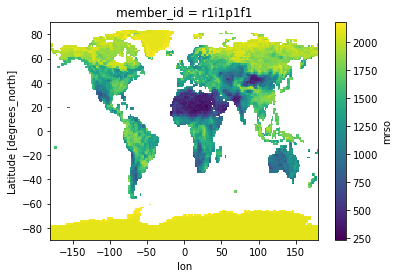

In [9]:
ds.sel(member_id = 'r1i1p1f1').mrso.mean(dim = 'time').plot()

In [10]:
import matplotlib.path as mplp
import numpy as np
import pandas as pd


df_regions = pd.read_csv("IPCC-WGI-reference-regions-v4_coordinates.csv")

def outline_to_mask(line, x, y):
    """Create mask from outline contour

    Parameters
    ----------
    line: array-like (N, 2)
    x, y: 1-D grid coordinates (input for meshgrid)

    Returns
    -------
    mask : 2-D boolean array (True inside)
    """

    mpath = mplp.Path(line)
    X, Y = np.meshgrid(x, y)
    points = np.array((X.flatten(), Y.flatten())).T
    mask = mpath.contains_points(points).reshape(X.shape)
    return mask

def IPCC_region(data, code):
    """Mask data outside AR6 reference region
    Requires https://github.com/IPCC-WG1/Atlas/blob/devel/reference-regions/IPCC-WGI-reference-regions-v4_coordinates.csv

    Parameters
    ----------
    data: array with shape (ntime,n_latitude,n_longitude)
    code: IPCC AR6 reference region code

    Returns
    -------
    ipcc_masked : array of shape (ntime, n_latitude,n_longitude) with values outside region masked
    """

    vals=df_regions[df_regions.Acronym==code].values[0]
    lons=[]
    lats=[]
    for x in vals:
        if type(x)==type("this"):
            if x.find("|")>0:
                lon,lat=x.split("|")

                lons+=[float(lon)]
                lats+=[float(lat)]
    N = len(lons)
    line = np.zeros((N,2))

    line[:,0] = np.array(lons)
    line[:,1] = np.array(lats)
    x = data.getLatitude()[:] #Edit based on datatype (may gave to change for xarray)
    y = data.getLongitude()[:]
    y = (y+ 180) % 360 - 180
    tmask =~ outline_to_mask(line,y,x)
    tmask.shape
    ipcc_masked = mask_data(data,tmask)
    
    return ipcc_masked


Regional Acronyms I'm interested in:
`MED`

In [11]:
ds

<xarray.Dataset>
Dimensions:    (lat: 144, lon: 192, member_id: 3, time: 5412)
Coordinates:
  * time       (time) object 1850-01-16 00:00:00 ... 2300-12-16 00:00:00
  * lat        (lat) float64 -89.38 -88.12 -86.88 -85.62 ... 86.88 88.12 89.38
  * lon        (lon) float64 -179.1 -177.2 -175.3 -173.4 ... 175.3 177.2 179.1
  * member_id  (member_id) <U8 'r1i1p1f1' 'r2i1p1f1' 'r3i1p1f1'
Data variables:
    pr         (member_id, time, lat, lon) float32 3.355e-06 3.073e-06 ... nan
    mrso       (member_id, time, lat, lon) float32 2.093e+03 2.093e+03 ... nan

In [12]:
vals=df_regions[df_regions.Acronym=='MED'].values[0]


In [13]:
vals

array(['EUROPE-AFRICA', 'Land-Ocean', 'Mediterranean', 'MED',
       '-10.0|30.0', '-10.0|45.0', '40.0|45.0', '40.0|30.0', nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan], dtype=object)

In [14]:
lons=[]
lats=[]
for x in vals:
    if type(x)==type("this"):
        if x.find("|")>0:
            lon,lat=x.split("|")

            lons+=[float(lon)]
            lats+=[float(lat)]
N = len(lons)
line = np.zeros((N,2))

line[:,0] = np.array(lons)
line[:,1] = np.array(lats)
#x = data.getLatitude()[:] #Edit based on datatype (may gave to change for xarray)
#y = data.getLongitude()[:]
#y = (y+ 180) % 360 - 180

x = ds['lat']
y = ds['lon']

tmask =~ outline_to_mask(line,y,x)
tmask.shape


(144, 192)

In [15]:
#ds.where(tmask == True)

In [16]:
import regionmask

In [17]:
import matplotlib.pyplot as plt

In [18]:
import xagg as xa
import geopandas as gpd

In [19]:
# Load US counties shapefile as a geopandas GeoDataFrame
gdf = gpd.read_file('IPCC-WGI-reference-regions-v4_shapefile/IPCC-WGI-reference-regions-v4.shp')

In [20]:
# Calculate overlaps
weightmap = xa.pixel_overlaps(ds,gdf)

creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.
calculating overlaps between pixels and output polygons...
success!


In [21]:
# Aggregate
aggregated = xa.aggregate(ds,weightmap)


aggregating pr...
aggregating mrso...
all variables aggregated to polygons!


In [22]:
# Example as a dataset
ds_out = aggregated.to_dataset()
ds_out



<xarray.Dataset>
Dimensions:    (member_id: 3, pix_idx: 58, time: 5412)
Coordinates:
  * pix_idx    (pix_idx) int64 0 1 2 3 4 5 6 7 8 ... 49 50 51 52 53 54 55 56 57
  * member_id  (member_id) <U8 'r1i1p1f1' 'r2i1p1f1' 'r3i1p1f1'
  * time       (time) object 1850-01-16 00:00:00 ... 2300-12-16 00:00:00
Data variables:
    Continent  (pix_idx) object 'POLAR' 'NORTH-AMERICA' ... 'INDIAN' 'SOUTHERN'
    Type       (pix_idx) object 'Land' 'Land' 'Land' ... 'Ocean' 'Ocean' 'Ocean'
    Name       (pix_idx) object 'Greenland/Iceland' ... 'Southern-Ocean'
    Acronym    (pix_idx) object 'GIC' 'NWN' 'NEN' 'WNA' ... 'EIO' 'SIO' 'SOO'
    pr         (pix_idx, member_id, time) float64 1.677e-05 2.315e-05 ... 0.0
    mrso       (pix_idx, member_id, time) float64 2.03e+03 2.03e+03 ... 0.0 0.0

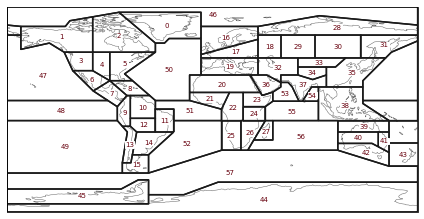

In [23]:
text_kws = dict(color="#67000d", fontsize=7, bbox=dict(pad=0.2, color="w"))

regionmask.defined_regions.ar6.all.plot(text_kws=text_kws);

plt.tight_layout()

In [24]:
ar6_region = regionmask.defined_regions.ar6.all
mask = regionmask.defined_regions.ar6.all.mask(ds)

In [25]:
def region_select(ds, region_params):
    """
    subset a dataset by region
    """
    region_ds = ds.sel(lat=slice(*region_params['lat']), lon=slice(*region_params['lon']))
    return region_ds

#region_params = {'lat':[25,55],'lon':[-15, 45]} # Mediterranean


In [26]:
med = ds.where((mask == ar6_region.map_keys('MED')))

In [35]:
med.pr.dropna

<bound method DataArray.dropna of <xarray.DataArray 'pr' (member_id: 3, time: 5412, lat: 144, lon: 192)>
array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
...
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

 

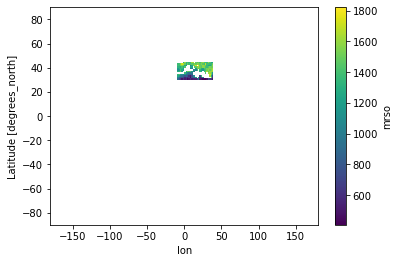

In [28]:
med.mrso.mean(dim = 'time').mean(dim = 'member_id').plot()

In [ ]:
import cartopy.crs as ccrs
import cartopy
from pyproj import Proj, Transformer, CRS
import geopandas
import rioxarray

# read california shape file
cali = geopandas.read_file('IPCC-WGI-reference-regions-v4.shp')

# set spatial dims, CRS for data (4326 is EPSG code for platecarree)
ds_cali = ds.rio.set_spatial_dims(x_dim="lon", y_dim="lat")
ds_cali.rio.write_crs("epsg:4326", inplace=True)

# clip data to shapefile
ds_cali = ds_cali.rio.clip(cali.geometry.apply(mapping), cali.crs, drop=False)

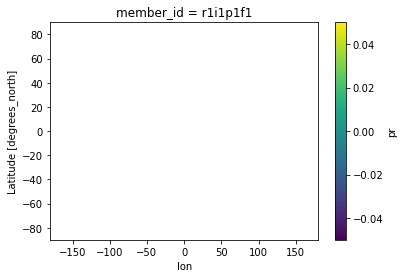

In [116]:
#ds.where(mask == '19').pr.mean(dim = 'time').sel(member_id = 'r1i1p1f1').plot()

In [102]:
ds.where(mask = 'MED')

TypeError: where() got an unexpected keyword argument 'mask'

In [83]:
ds.where(mask)

AttributeError: 'numpy.ndarray' object has no attribute 'variables'

In [72]:
ds.where(regionmask.defined_regions.ar6.all['MED'])

AttributeError: 'numpy.ndarray' object has no attribute 'variables'

In [4]:
import xarray as xr 
import pandas as pd
import numpy as np

In [5]:
np.random.seed(0)

temperature = 15 + 8 * np.random.randn(2, 2, 3)

precipitation = 10 * np.random.rand(2, 2, 3)

lon = [[-99.83, -99.32], [-99.79, -99.23]]

lat = [[42.25, 42.21], [42.63, 42.59]]

time = pd.date_range("2014-09-06", periods=3)

reference_time = pd.Timestamp("2014-09-05")

In [6]:
ds = xr.Dataset(

    data_vars=dict(

        temperature=(["x", "y", "time"], temperature),

        precipitation=(["x", "y", "time"], precipitation),

    ),

    coords=dict(

        lon=(["x", "y"], lon),

        lat=(["x", "y"], lat),

        time=time,

        reference_time=reference_time,

    ),

    attrs=dict(description="Weather related data."),

)

ds

<xarray.Dataset>
Dimensions:         (time: 3, x: 2, y: 2)
Coordinates:
    lon             (x, y) float64 -99.83 -99.32 -99.79 -99.23
    lat             (x, y) float64 42.25 42.21 42.63 42.59
  * time            (time) datetime64[ns] 2014-09-06 2014-09-07 2014-09-08
    reference_time  datetime64[ns] 2014-09-05
Dimensions without coordinates: x, y
Data variables:
    temperature     (x, y, time) float64 29.11 18.2 22.83 ... 18.28 16.15 26.63
    precipitation   (x, y, time) float64 5.68 9.256 0.7104 ... 7.992 4.615 7.805
Attributes:
    description:  Weather related data.

In [13]:
ds.mean(dim = 'time')

<xarray.Dataset>
Dimensions:         (x: 2, y: 2)
Coordinates:
    lon             (x, y) float64 -99.83 -99.32 -99.79 -99.23
    lat             (x, y) float64 42.25 42.21 42.63 42.59
    reference_time  datetime64[ns] 2014-09-05
Dimensions without coordinates: x, y
Data variables:
    temperature     (x, y) float64 23.38 23.35 16.85 20.36
    precipitation   (x, y) float64 5.216 3.133 8.756 6.804